## Projet InSIGHT-PHAC


### Code pour convertir un shapefile en netcdf 

In [2]:
import xarray as xr
from osgeo import ogr
import numpy as np
import geopandas as gpd
import warnings
warnings.filterwarnings("ignore")

model='ERA5'

#########################################################
file_in = 'K:/DATA/REANALYSES/ERA5/Mean_T2m/'
file_out = 'D:/Utilisateurs/guillaume/Documents/GitHub/InSIGHT-PHAC/Mask_Old/' 
#file_out = 'D:/Utilisateurs/guillaume/Documents/GitHub/InSIGHT-PHAC/Mask/' 

data = file_in +'Monthly_Mean_t2m_198501.nc'
ds = xr.open_mfdataset(data)

La fonction ci-dessous permet d'aller récupérer le contour d'un shapefile et de détecter si les points de grille se situent à l'intérieur des polygones.

In [3]:
def get_mask(lons2d, lats2d, shp_path="", polygon_name=None):
    """
    Assumes that the shape file contains polygons in lat lon coordinates
    :param lons2d:
    :param lats2d:
    :param shp_path:
    :rtype : np.ndarray
    The mask is 1 for the points inside of the polygons
    """
    ds = ogr.Open(shp_path)
    """
    :type : ogr.DataSource
    """

    xx = lons2d.copy()
    yy = lats2d

    # set longitudes to be from -180 to 180
    xx[xx > 180] -= 360

    mask = np.zeros(lons2d.shape, dtype=int)
    nx, ny = mask.shape

    pt = ogr.Geometry(ogr.wkbPoint)

    for i in range(ds.GetLayerCount()):
        layer = ds.GetLayer(i)
        """
        :type : ogr.Layer
        """

        for j in range(layer.GetFeatureCount()):
            feat = layer.GetFeature(j)
            """
            :type : ogr.Feature
            """

            # Select polygons by the name property
            if polygon_name is not None:
                if not feat.GetFieldAsString("name") == polygon_name:
                    continue

            g = feat.GetGeometryRef()
            """
            :type : ogr.Geometry
            """

            assert isinstance(g, ogr.Geometry)

            for pi in range(nx):
                for pj in range(ny):
                    pt.SetPoint_2D(0, float(xx[pi, pj]), float(yy[pi, pj]))

                    mask[pi, pj] += int(g.Contains(pt))

    return mask

Ouverture des shapefiles à masquer. 

In [5]:
Imp_Lats =  ds['latitude'].values
Imp_Lons =  ds['longitude'].values
lon2d, lat2d = np.meshgrid(Imp_Lons, Imp_Lats)
shapes = gpd.read_file("D:/Utilisateurs/guillaume/Documents/GitHub/InSIGHT-PHAC/Countries/Countries_Final-polygon.shp")
list(shapes.columns.values)

['FIPS',
 'ISO2',
 'ISO3',
 'UN',
 'NAME',
 'AREA',
 'POP2005',
 'REGION',
 'SUBREGION',
 'LON',
 'LAT',
 'layer',
 'path',
 'geometry']

In [18]:
shapes.head()

,FIPS,ISO2,ISO3,UN,NAME,AREA,POP2005,REGION,SUBREGION,LON,LAT,layer,path,geometry
0,NT,AN,ANT,530,Bonaire,80,186392,19,29,-68.870,12.123,Single parts,C:/Users/Aspire/Desktop/ZIKA analysis with new...,POLYGON ((-68.19528200000002 12.22110899999996...
1,NT,AN,ANT,530,Curacao,80,186392,19,29,-68.870,12.123,Single parts,C:/Users/Aspire/Desktop/ZIKA analysis with new...,POLYGON ((-68.96556099999998 12.19888900000001...
2,NT,AN,ANT,530,Netherlands Antilles,80,186392,19,29,-68.870,12.123,Single parts,C:/Users/Aspire/Desktop/ZIKA analysis with new...,"POLYGON ((-62.96111299999995 17.4608310000001,..."
3,AC,AG,ATG,28,Antigua and Barbuda,44,83039,19,29,-61.783,17.078,Studied_countries,C:\Users\Aspire\Desktop\ZIKA analysis with new...,"(POLYGON ((-61.686668 17.02444100000014, -61.7..."
4,AR,AR,ARG,32,Argentina,273669,38747148,19,5,-65.167,-35.377,Studied_countries,C:\Users\Aspire\Desktop\ZIKA analysis with new...,(POLYGON ((-68.60861199999994 -54.891395999999...


In [19]:
print(shapes['NAME'][46])

United States


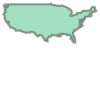

In [20]:
shapes.loc[46, 'geometry']

Avec la fonction ci-dessus, nous allons détecter les points de grille de ERA5 qui se trouvent dans le shapefile United States.

In [22]:
mask=get_mask(lon2d,lat2d,shp_path="D:/Utilisateurs/guillaume/Documents/GitHub/InSIGHT-PHAC/Countries/Countries_Final-polygon.shp", polygon_name=shapes['NAME'][46]) 
mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

On va sauver notre masque aux formats netcdf  et numpy. 

In [24]:
np.save(file_out + 'mask_'+str(shapes['NAME'][46].replace(' ','_'))+'.npy',mask)
ds_mask = ds.where(mask == 1)
ds_mask.to_netcdf(file_out + 'mask_'+str(shapes['NAME'][46].replace(' ','_'))+'.nc')

In [28]:
from netCDF4 import Dataset
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pylab as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import matplotlib as mpl

In [39]:
file_name = str(file_out + 'mask_'+str(shapes['NAME'][46].replace(' ','_'))+'.nc')
dset=Dataset(file_name)
dset.variables

OrderedDict([('t2m', <class 'netCDF4._netCDF4.Variable'>
              float32 t2m(time, latitude, longitude)
                  _FillValue: nan
              unlimited dimensions: 
              current shape = (1, 721, 1440)
              filling on), ('time', <class 'netCDF4._netCDF4.Variable'>
              int64 time(time)
                  units: days since 1985-01-31
                  calendar: proleptic_gregorian
              unlimited dimensions: 
              current shape = (1,)
              filling on, default _FillValue of -9223372036854775806 used), ('longitude',
              <class 'netCDF4._netCDF4.Variable'>
              float32 longitude(longitude)
                  _FillValue: nan
                  standard_name: longitude
                  long_name: longitude
                  units: degrees_east
                  axis: X
              unlimited dimensions: 
              current shape = (1440,)
              filling on), ('latitude', <class 'netCDF4._netCDF4.V

In [41]:
lats = dset.variables['latitude'][:]  
lons = dset.variables['longitude'][:]
Vals = dset.variables['t2m'][:].squeeze()

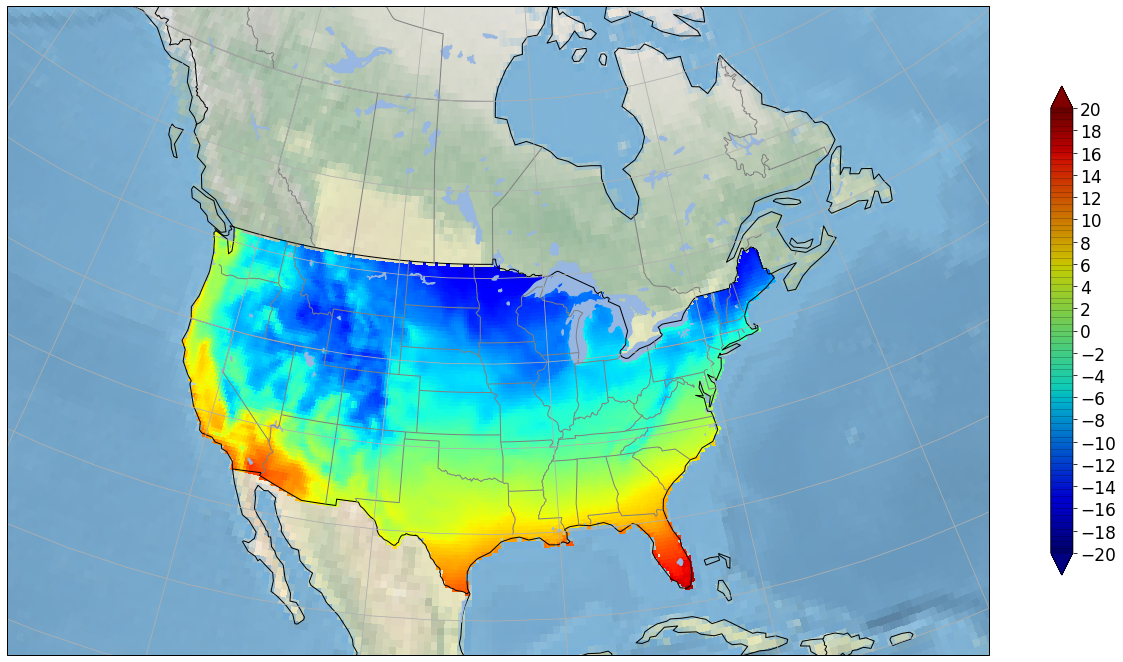

In [46]:
fig = plt.figure(figsize=(22,12))

ax = plt.subplot(111, projection=ccrs.LambertConformal())
ax.set_extent([-130,-60,18,62])
ax.coastlines(resolution='110m');
ax.add_feature(cfeature.OCEAN.with_scale('50m'))
ax.add_feature(cfeature.LAND.with_scale('50m'))
ax.add_feature(cfeature.LAKES.with_scale('50m'))
ax.add_feature(cfeature.BORDERS.with_scale('50m'))

## Choisissons une colormap
cmap0=plt.cm.jet

mm = ax.pcolormesh(lons,\
                   lats,\
                   Vals,\
                   vmin=-20,\
                   vmax=20, \
                   transform=ccrs.PlateCarree(),\
                   cmap=cmap0 )

states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

ax.add_feature(states_provinces, edgecolor='gray')  
ax.stock_img();

ax.gridlines()

# Define gridline locations and draw the lines using cartopy's built-in gridliner:
xticks = np.arange(-150.0,-40.0,20)
yticks =np.arange(10,80,10)

fig.canvas.draw()

cbar = plt.colorbar(mm, shrink=0.75, drawedges='True', ticks=np.arange(-20, 20.1, 2),extend='both')
cbar.ax.tick_params(labelsize=17) 

plt.savefig('./OLD_MASK_USA.png', bbox_inches='tight', pad_inches=0.1,  dpi=150)
plt.show()  
plt.close()

Tracé du nouveau masque avec les zones de probabilités. 

In [ ]:
file_name = str(file_out + 'mask_'+str(shapes['NAME'][46].replace(' ','_'))+'.nc')
dset=Dataset(file_name)
dset.variables
lats = dset.variables['latitude'][:]  
lons = dset.variables['longitude'][:]
Vals = dset.variables['t2m'][:].squeeze()
fig = plt.figure(figsize=(22,12))

ax = plt.subplot(111, projection=ccrs.LambertConformal())
ax.set_extent([-130,-60,18,62])
ax.coastlines(resolution='110m');
ax.add_feature(cfeature.OCEAN.with_scale('50m'))
ax.add_feature(cfeature.LAND.with_scale('50m'))
ax.add_feature(cfeature.LAKES.with_scale('50m'))
ax.add_feature(cfeature.BORDERS.with_scale('50m'))

## Choisissons une colormap
cmap0=plt.cm.jet

mm = ax.pcolormesh(lons,\
                   lats,\
                   Vals,\
                   vmin=-20,\
                   vmax=20, \
                   transform=ccrs.PlateCarree(),\
                   cmap=cmap0 )

states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

ax.add_feature(states_provinces, edgecolor='gray')  
ax.stock_img();

ax.gridlines()

# Define gridline locations and draw the lines using cartopy's built-in gridliner:
xticks = np.arange(-150.0,-40.0,20)
yticks =np.arange(10,80,10)

fig.canvas.draw()

cbar = plt.colorbar(mm, shrink=0.75, drawedges='True', ticks=np.arange(-20, 20.1, 2),extend='both')
cbar.ax.tick_params(labelsize=17) 

plt.savefig('./NEW_MASK_USA.png', bbox_inches='tight', pad_inches=0.1,  dpi=150)
plt.show()  
plt.close()